In [1]:
from src.generator import data_generator, clip_generator, label_generator
from src.util import characters, id_from_char, char_from_id

from pymongo import MongoClient
from tensorflow import keras

import numpy as np
import pickle

In [2]:
for character in characters:
    print(character)

CAPTAIN_FALCON
DONKEY_KONG
FOX
GAME_AND_WATCH
KIRBY
BOWSER
LINK
LUIGI
MARIO
MARTH
MEWTWO
NESS
PEACH
PIKACHU
ICE_CLIMBERS
JIGGLYPUFF
SAMUS
YOSHI
ZELDA
SHEIK
FALCO
YOUNG_LINK
DR_MARIO
ROY
PICHU
GANONDORF


# The Model

Source code for model creation is in src/models.py

In [3]:
from tensorflow.keras.optimizers import Adam, Nadam
adam = Adam(learning_rate=0.00001)
nadam = Nadam(learning_rate=0.0001)

In [4]:
# # to make a new model
from src.models import custom_mk2 as Model
# model = Model()

# to load the saved model
model = keras.models.load_model('models/custom_mk2')

from src.models import focal_loss, top_8_accuracy
model.compile(loss=focal_loss,
              optimizer=adam,
              metrics=['accuracy', top_8_accuracy])

In [5]:
model.summary()

Model: "custom_mk2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, None, 150)         58650     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 150)         0         
_________________________________________________________________
conv2.1 (Conv1D)             (None, None, 128)         288128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv3.1 (Conv1D)             (None, None, 128)         245888    
_________________________________________________________________
conv3.2 (Conv1D)             (None, None, 128)         245888    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0

# Testing

In [11]:
database_name = 'slippi'
collection_name = 'melee_clips_30s'

# Connect to the hosted MongoDB instance
client = MongoClient('localhost', 27017)
db = client[database_name]
collection = db[collection_name]
collection.estimated_document_count()

916647

In [12]:
batch_size = 100
skip = None    # no skip because first 100k clips are test data
step = 13       # to ensure that consecutive clips aren't from the same player and game
repeat = True  # keep this as True, allows generator to loop through database infinitley
limit = 100000 # only look at test data (first 100k clips)

num_batches = 100

In [13]:
data_test = data_generator(clip_collection=collection,
                           batch_size = batch_size,
                           skip=skip,
                           step=step,
                           repeat=repeat,
                           limit=limit)

X_test = clip_generator(clip_collection=collection,
                        batch_size = batch_size,
                        skip=skip,
                        step=step,
                        repeat=repeat,
                        limit=limit)

Y_test = label_generator(clip_collection=collection,
                         batch_size = batch_size,
                         skip=skip,
                         step=step,
                         repeat=repeat,
                         limit=limit, 
                         onehot=True)

y_test = label_generator(clip_collection=collection,
                         batch_size = batch_size,
                         skip=skip,
                         step=step,
                         repeat=repeat,
                         limit=limit,
                         onehot=False)

In [14]:
score = model.evaluate(data_test, steps=num_batches, verbose=1)

print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 categorical accuracy: {round(score[2]*100)}%') 

100/100 [==============================] - 86s 855ms/step - loss: 0.0413 - accuracy: 0.9324 - top 8 accuracy: 0.9788

Test score: 0.041
Test accuracy: 93%
Test test top 8 categorical accuracy: 98%


# Confusion Matrix

In [15]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [16]:
def get_conf_matrix(labels_as_id, predictions_as_id):
    conf_matrix = np.zeros((27,27))
    for i_real, i_pred in zip(labels_as_id, predictions_as_id):
        conf_matrix[i_real, i_pred] += 1
    return conf_matrix

In [17]:
recalls = {k:0 for k in range(1,27)}
precisions = {k:0 for k in range(1,27)}

pred = np.argmax(model.predict(X_test, steps=num_batches, verbose=1), axis = 1)

if repeat:
    labels = np.concatenate([next(y_test) for _ in range(num_batches)])
else:
    labels = np.concatenate([label for label in y_test])

conf_matrix = get_conf_matrix(labels, pred)
conf_df = pd.DataFrame(conf_matrix[1:,1:], index=characters, columns=characters)

100/100 [==============================] - 86s 861ms/step


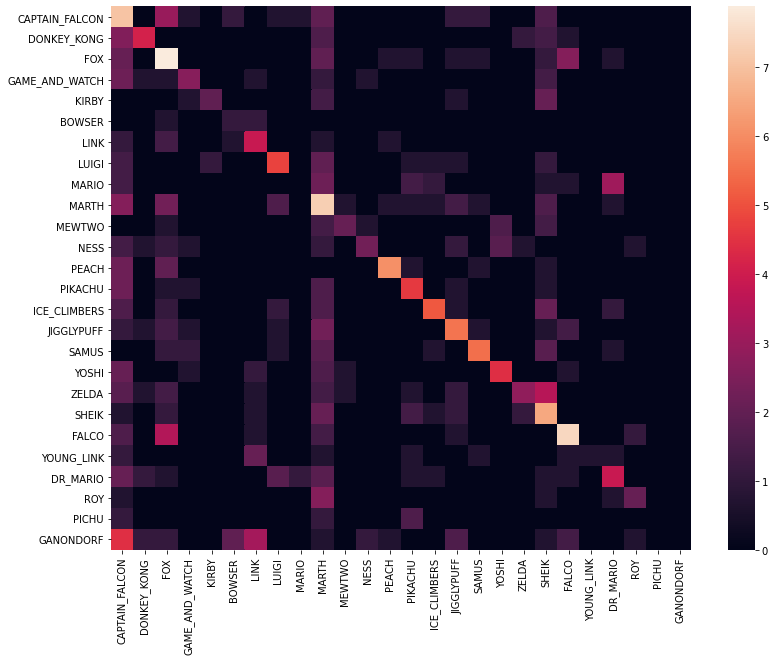

In [18]:
# sn.heatmap(conf_df, annot=False, mask=conf_df <= 0, cmap='viridis')
fig, ax = plt.subplots(figsize=(13,10))
sn.heatmap(np.log(1 + conf_df), annot=False, ax=ax, square=False)
fig.savefig('images/confusion_matrix.png')

# Training

In [6]:
database_name = 'slippi'
collection_name = 'melee_clips_30s'

# Connect to the hosted MongoDB instance
client = MongoClient('localhost', 27017)
db = client[database_name]
collection = db[collection_name]

In [7]:
# skip first 100k clips and save them as test data
data = data_generator(collection, batch_size=100, skip=100000, step=29, repeat=True)

In [8]:
# custom_mk2
model.fit(data, epochs=10, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

Epoch 1/10
500/500 [==============================] - 1424s 3s/step - loss: 0.3259 - accuracy: 0.5133 - top 8 accuracy: 0.9038
Epoch 2/10
500/500 [==============================] - 1421s 3s/step - loss: 0.1746 - accuracy: 0.7583 - top 8 accuracy: 0.9426
Epoch 3/10
500/500 [==============================] - 1419s 3s/step - loss: 0.1332 - accuracy: 0.8159 - top 8 accuracy: 0.9557
Epoch 4/10
500/500 [==============================] - 1419s 3s/step - loss: 0.1133 - accuracy: 0.8399 - top 8 accuracy: 0.9615
Epoch 5/10
500/500 [==============================] - 1419s 3s/step - loss: 0.0999 - accuracy: 0.8592 - top 8 accuracy: 0.9651
Epoch 6/10
500/500 [==============================] - 1420s 3s/step - loss: 0.0905 - accuracy: 0.8709 - top 8 accuracy: 0.9669
Epoch 7/10
500/500 [==============================] - 1427s 3s/step - loss: 0.0835 - accuracy: 0.8806 - top 8 accuracy: 0.9690
Epoch 8/10
500/500 [==============================] - 1421s 3s/step - loss: 0.0801 - accuracy: 0.8832 - top 8 a

In [9]:
model.save('models/custom_mk2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [10]:
# skip first 100k clips and save them as test data
data = data_generator(collection, batch_size=100, skip=100000, step=11, repeat=True)

In [11]:
# custom_mk2
model.fit(data, epochs=10, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

Epoch 1/10
500/500 [==============================] - 1427s 3s/step - loss: 0.0717 - accuracy: 0.8951 - top 8 accuracy: 0.9721
Epoch 2/10
500/500 [==============================] - 1424s 3s/step - loss: 0.0676 - accuracy: 0.8987 - top 8 accuracy: 0.9719
Epoch 3/10
500/500 [==============================] - 1436s 3s/step - loss: 0.0658 - accuracy: 0.9023 - top 8 accuracy: 0.9731
Epoch 4/10
500/500 [==============================] - 1430s 3s/step - loss: 0.0659 - accuracy: 0.9027 - top 8 accuracy: 0.9728
Epoch 5/10
500/500 [==============================] - 1444s 3s/step - loss: 0.0633 - accuracy: 0.9043 - top 8 accuracy: 0.9735
Epoch 6/10
500/500 [==============================] - 1429s 3s/step - loss: 0.0617 - accuracy: 0.9084 - top 8 accuracy: 0.9742
Epoch 7/10
500/500 [==============================] - 1428s 3s/step - loss: 0.0649 - accuracy: 0.9042 - top 8 accuracy: 0.9731
Epoch 8/10
500/500 [==============================] - 1436s 3s/step - loss: 0.0614 - accuracy: 0.9080 - top 8 a

In [12]:
model.save('models/custom_mk2')

In [8]:
# custom_mk2
model.fit(data, epochs=10, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

Epoch 1/10
500/500 [==============================] - 1448s 3s/step - loss: 0.0536 - accuracy: 0.9183 - top 8 accuracy: 0.9757
Epoch 2/10
500/500 [==============================] - 1452s 3s/step - loss: 0.0505 - accuracy: 0.9206 - top 8 accuracy: 0.9750
Epoch 3/10
500/500 [==============================] - 1444s 3s/step - loss: 0.0487 - accuracy: 0.9243 - top 8 accuracy: 0.9765
Epoch 4/10
500/500 [==============================] - 1436s 3s/step - loss: 0.0485 - accuracy: 0.9239 - top 8 accuracy: 0.9758
Epoch 5/10
500/500 [==============================] - 1431s 3s/step - loss: 0.0485 - accuracy: 0.9245 - top 8 accuracy: 0.9767
Epoch 6/10
500/500 [==============================] - 1434s 3s/step - loss: 0.0468 - accuracy: 0.9253 - top 8 accuracy: 0.9756
Epoch 7/10
500/500 [==============================] - 1435s 3s/step - loss: 0.0447 - accuracy: 0.9279 - top 8 accuracy: 0.9774
Epoch 8/10
500/500 [==============================] - 1434s 3s/step - loss: 0.0469 - accuracy: 0.9241 - top 8 a

In [20]:
model.save('models/custom_mk2')

In [19]:
# custom_mk2
model.fit(data, epochs=5, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

Epoch 1/5
500/500 [==============================] - 1426s 3s/step - loss: 0.0450 - accuracy: 0.9280 - top 8 accuracy: 0.9771
Epoch 2/5
500/500 [==============================] - 1428s 3s/step - loss: 0.0449 - accuracy: 0.9255 - top 8 accuracy: 0.9766
Epoch 3/5
500/500 [==============================] - 1428s 3s/step - loss: 0.0439 - accuracy: 0.9293 - top 8 accuracy: 0.9778
Epoch 4/5
500/500 [==============================] - 1424s 3s/step - loss: 0.0436 - accuracy: 0.9298 - top 8 accuracy: 0.9774
Epoch 5/5
500/500 [==============================] - 1434s 3s/step - loss: 0.0436 - accuracy: 0.9292 - top 8 accuracy: 0.9766

Test score: 0.042
Test accuracy: 93%
Test test top 8 accuracy: 98%
